# Lesson 1: VGG16 From Scratch

In [10]:
import json

import numpy as np
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Dropout, Dense, Flatten, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend
from matplotlib import pyplot as plt
from keras.optimizers import Adam

In [11]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [12]:
data_path = '/home/ubuntu/nbs/data/'

In [13]:
FILES_PATH = 'https://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir='models')

In [14]:
with open(fpath) as f:
    class_dict = json.load(f)

# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

## Model creation

Define the basic pieces of the VGG architecture: one type of convolutional block and one type of fully connected "dense" block. Convolutional block definition:

In [15]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

Fully-connected definition:

In [16]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

Model creators subtracted the mean from each RGB value. Also, the values are provided as BGR for some reason...

In [17]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [18]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(1000, activation='softmax'))
    
    return model

def finetune(model, batches):
    model.pop()
    for layer in model.layers:
        layer.trainable = False

    model.add(Dense(batches.nb_class, activation='softmax'))
    model.compile(
        optimizer=Adam(lr=0.001),
        loss='categorical_crossentropy', metrics=['accuracy'])
    return model

* Convolutional blocks are for finding patterns in images.
* Dense (fully connected) blocks are for finding relationship betweens patterns.

In [20]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170601/train', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
val_batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170601/test', target_size=(224, 224),
    class_mode='categorical', batch_size=4)

Found 6450 images belonging to 3 classes.
Found 668 images belonging to 3 classes.


In [21]:
model = VGG_16()

In [22]:
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [23]:
model = finetune(model, batches)

In [24]:
model.fit_generator(
    batches, samples_per_epoch=batches.nb_sample,
    nb_epoch=3, validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample)

Epoch 1/3
3728/6450 [================>.............] - ETA: 69s - loss: 1.1869 - acc: 0.7747

/home/ubuntu/anaconda2/lib/python2.7/site-packages/PIL/Image.py:869: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


6450/6450 [==============================] - 182s - loss: 1.1796 - acc: 0.7924 - val_loss: 0.7613 - val_acc: 0.8488
Epoch 2/3
6450/6450 [==============================] - 184s - loss: 1.2381 - acc: 0.8166 - val_loss: 0.8472 - val_acc: 0.8518
Epoch 3/3
6450/6450 [==============================] - 183s - loss: 1.2671 - acc: 0.8313 - val_loss: 1.0776 - val_acc: 0.8488


## Checkout the validation set

In [26]:
%matplotlib inline

from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(data_path + 'male_female_training_set_20170601/test/{0}'.format(filenames[i])) for i in idx], titles=titles)

In [27]:
val_batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170601/test', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
probs = model.predict_generator(val_batches, val_batches.nb_sample)

Found 668 images belonging to 3 classes.


In [28]:
labels = val_batches.classes
filenames = val_batches.filenames

In [29]:
# Get argmax for each row. Should return either 0, 1 or 2.
preds = np.argmax(probs, axis=1)

### Correct labels at random

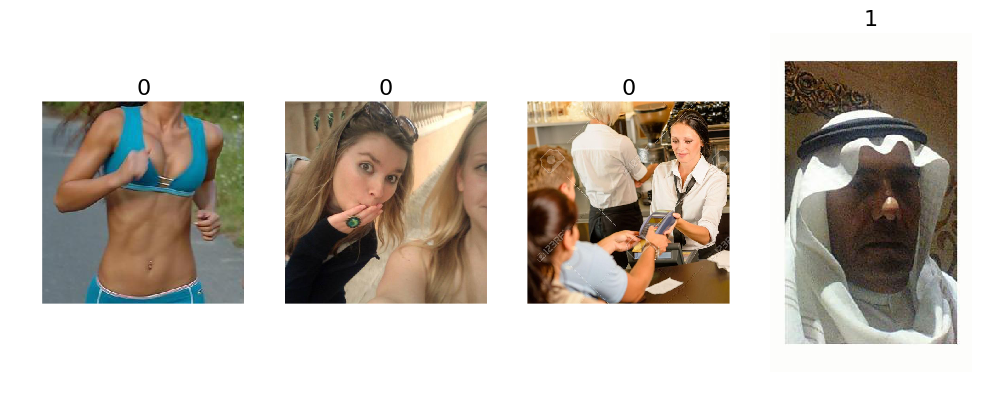

In [35]:
correct = np.where(preds==labels)[0]
idx = np.random.permutation(correct)[:4]
plots_idx(idx, preds[idx])

### Incorrect labels at random

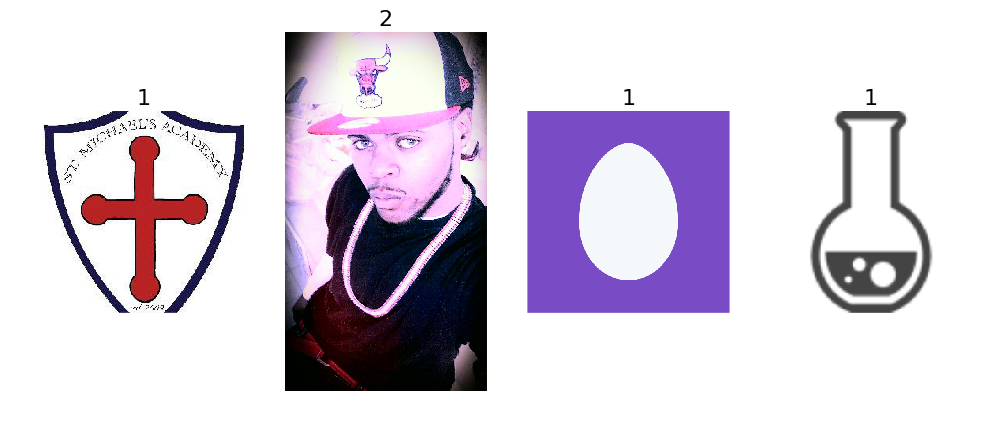

In [38]:
correct = np.where(preds!=labels)[0]
idx = np.random.permutation(correct)[:4]
plots_idx(idx, preds[idx])

In [39]:
def get_most_correct(label):
    correct = np.where((preds == label) & (preds == labels))[0]
    most_correct = np.argsort(probs[correct][:,label])[::-1][:4]
    plots_idx(correct[most_correct], probs[correct][most_correct])
    
def get_most_incorrect(label):
    incorrect = np.where((preds == label) & (preds != labels))[0]
    most_incorrect = np.argsort(probs[incorrect][:,label])[:4]
    plots_idx(incorrect[most_incorrect], probs[incorrect][most_incorrect])
    
def get_highest_uncertainy(label):
    correct = np.where((preds == label) & (preds == labels))[0]
    most_correct = np.argsort(probs[correct][:,label])[:4]
    plots_idx(correct[most_correct], probs[correct][most_correct])

### Display 4 of the most certain from each category.

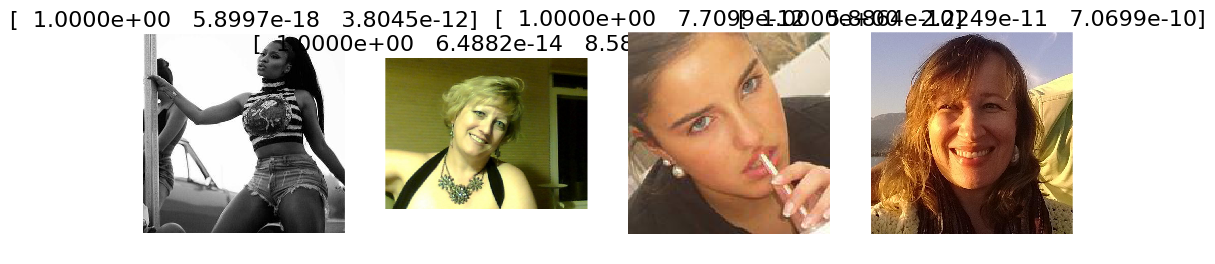

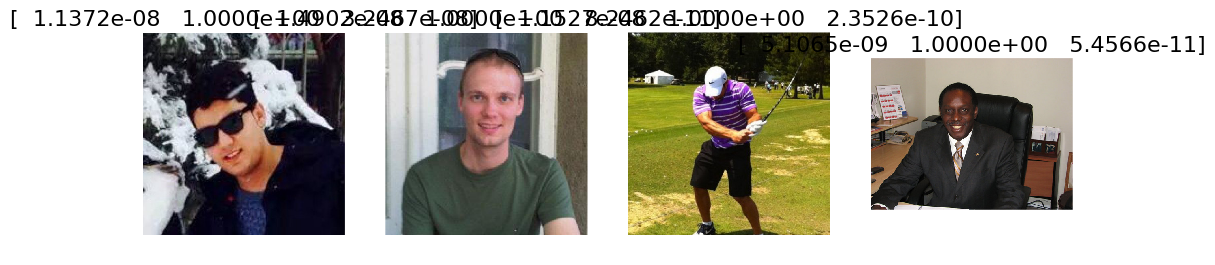

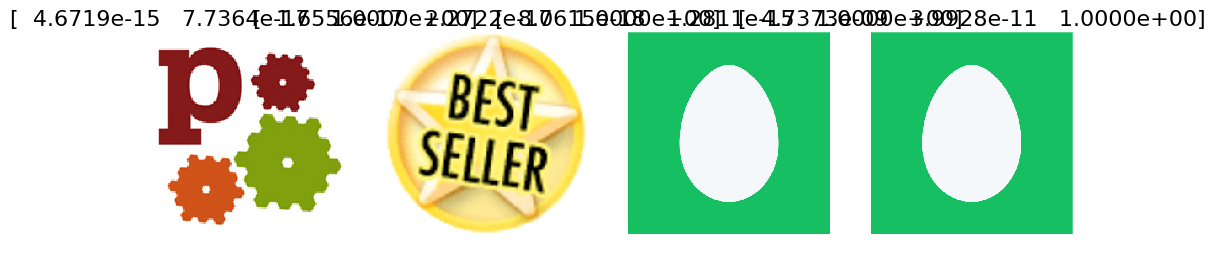

In [40]:
BRAND = 0; FEMALE = 1; MALE = 2

get_most_correct(BRAND)
get_most_correct(FEMALE)
get_most_correct(MALE)

### Display 4 that are incorrect with high probabilities.

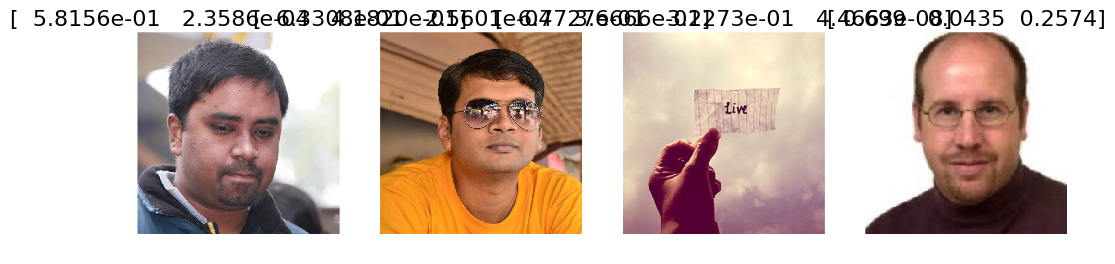

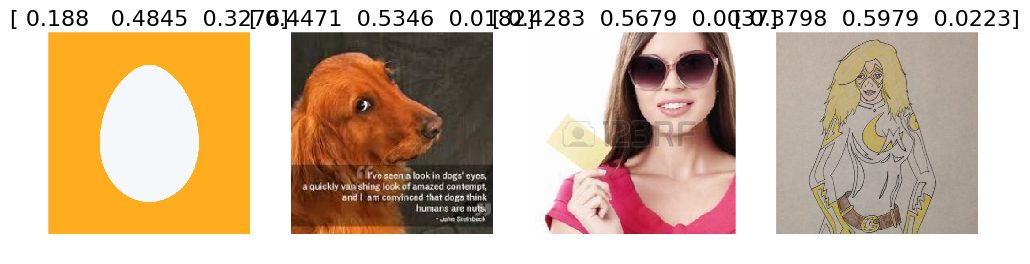

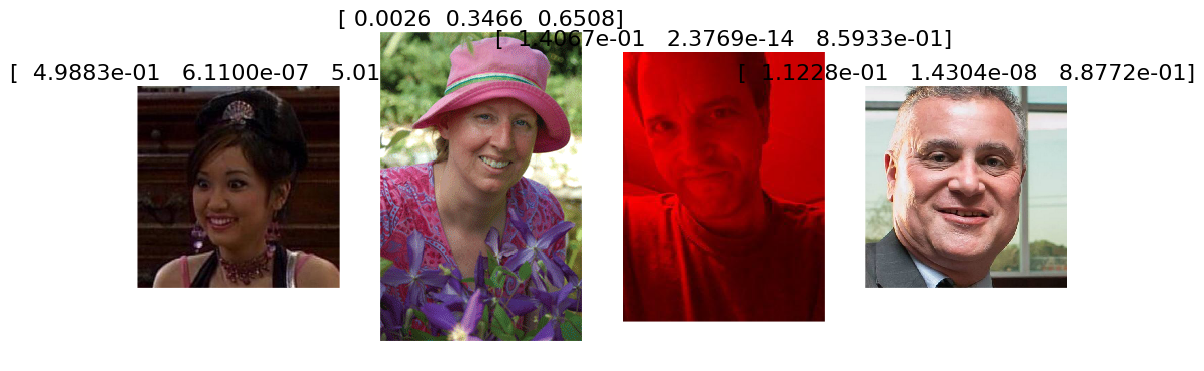

In [41]:
BRAND = 0; FEMALE = 1; MALE = 2

get_most_incorrect(BRAND)
get_most_incorrect(FEMALE)
get_most_incorrect(MALE)

### Highest uncertainy.

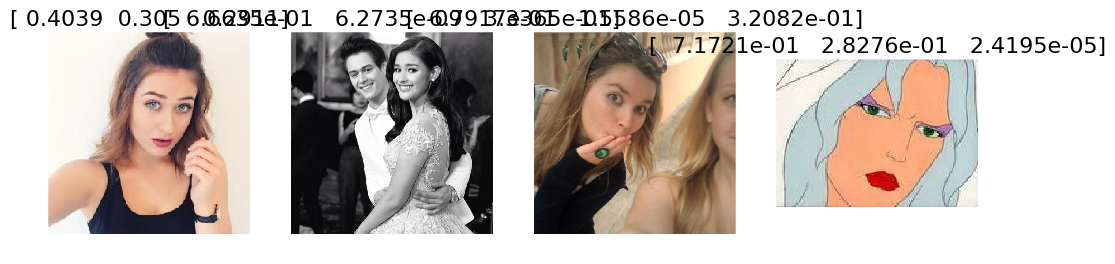

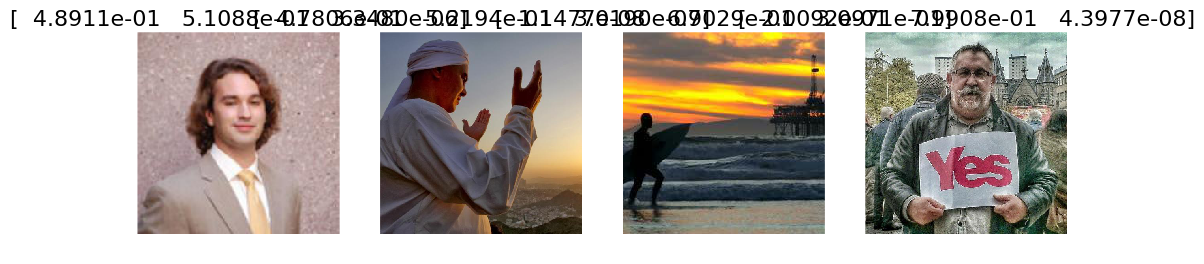

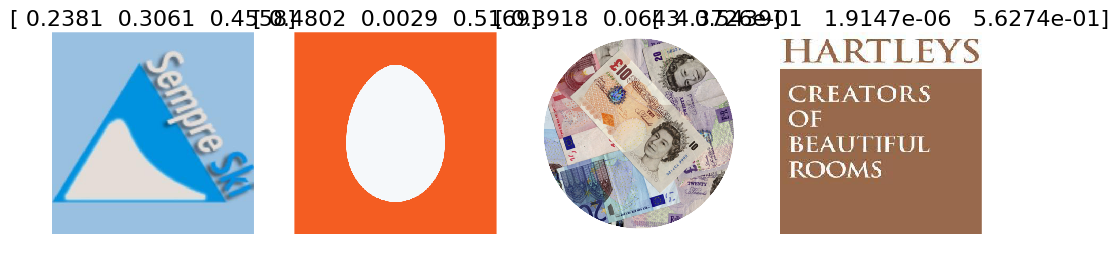

In [42]:
get_highest_uncertainy(BRAND)
get_highest_uncertainy(FEMALE)
get_highest_uncertainy(MALE)

### Attempt to increase performance with data augmentation

In [48]:
from keras.preprocessing.image import ImageDataGenerator

aug_gen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

In [ ]:
batches = aug_gen.flow_from_directory(
    data_path + 'male_female_training_set_20170601/train', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
val_batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170601/test', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
model = VGG_16()
model.load_weights(fpath)
model = finetune(model, batches)
model.fit_generator(
    batches, samples_per_epoch=batches.nb_sample,
    nb_epoch=3, validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample)

Found 6450 images belonging to 3 classes.
Found 668 images belonging to 3 classes.
Epoch 1/3
5592/6450 [=========================>....] - ETA: 22s - loss: 1.4077 - acc: 0.4778

So it seems like data augementation actually does worse for this problem? Interesting.